In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import jaccard_similarity_score

In [2]:
train = pd.read_csv("../../data/train.csv")
test = pd.read_csv("../../data/test.csv")
sample_sub = pd.read_csv("../../data/sample_submission.csv")

In [3]:
print(train.shape)
print(test.shape)

(27481, 4)
(3534, 3)


In [4]:
sample_sub.head(2)

,textID,selected_text
0,f87dea47db,NaN
1,96d74cb729,NaN


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3534 entries, 0 to 3533
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   textID     3534 non-null   object
 1   text       3534 non-null   object
 2   sentiment  3534 non-null   object
dtypes: object(3)
memory usage: 83.0+ KB


----

References: https://www.kaggle.com/tanulsingh077/twitter-sentiment-extaction-analysis-eda-and-model

In [7]:
train.dropna(inplace=True)

In [8]:
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [9]:
test.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


In [10]:
train.describe()

,textID,text,selected_text,sentiment
count,27480,27480,27480,27480
unique,27480,27480,22463,3
top,662ed69976,has one more paper left,good,neutral
freq,1,1,199,11117


Distribution of sentiments in training set:

In [11]:
tmp = (train[['textID', 'sentiment']]
       .groupby('sentiment')
       .count()
       .reset_index()
       .sort_values('textID', ascending=False)
      )
tmp.columns = ['sentiment', 'count']
tmp.style.background_gradient(cmap='Purples')

,sentiment,count
1,neutral,11117
2,positive,8582
0,negative,7781


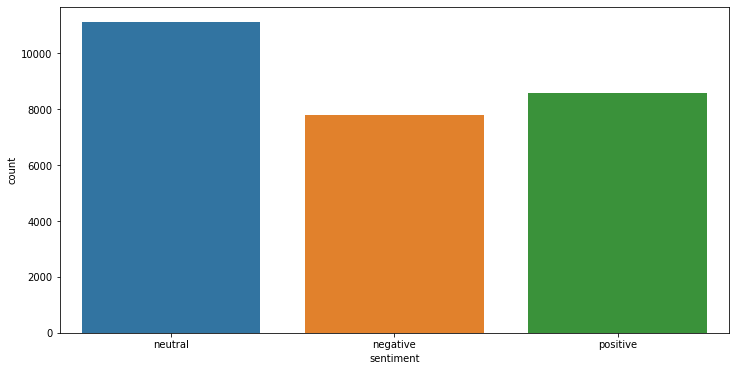

In [12]:
plt.figure(figsize=(12,6))
sns.countplot(data=train, x='sentiment')

In [13]:
##############
##   PREP   ##
##############
def compute_jaccard_sim(text1: str, text2: str) -> float: 
    a = set(text1.split()) 
    b = set(text2.split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

apply_jaccard_sim = lambda row: compute_jaccard_sim(row['text'], row['selected_text'])

def count_words(text: str) -> int:
    split_text = text.split()
    return len(split_text)

def count_words_in_column(row: pd.core.series.Series, column:str) -> int:
    return count_words(row[column])


################
##   ACTION   ##
################
train['jaccard_score'] = train.apply(apply_jaccard_sim, axis=1)
train['num_words_st'] = train.apply(count_words_in_column, args=['selected_text'], axis=1)
train['num_words_text'] = train.apply(count_words_in_column, args=['text'], axis=1)
train['difference_in_words'] = train['num_words_text'] - train['num_words_st']

train.head()

,textID,text,selected_text,sentiment,jaccard_score,num_words_st,num_words_text,difference_in_words
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,1.000000,7,7,0
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,0.200000,2,10,8
2,088c60f138,my boss is bullying me...,bullying me,negative,0.166667,2,5,3
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0.600000,3,5,2
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,0.214286,3,14,11


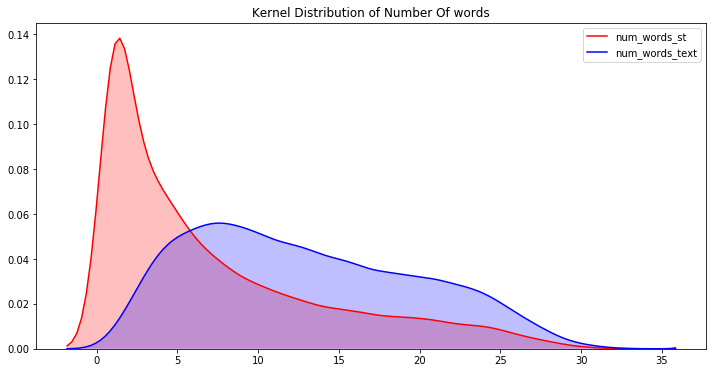

In [25]:
##############
##   PREP   ##
##############
plt.figure(figsize=(12,6))
num_words_selected_text = train['num_words_st']
num_words_text = train['num_words_text']


################
##   ACTION   ##
################
p1=(sns
    .kdeplot(num_words_selected_text, shade=True, color="r")
    .set_title('Kernel Distribution of Number Of words')
   )

p2=sns.kdeplot(num_words_text, shade=True, color="b")

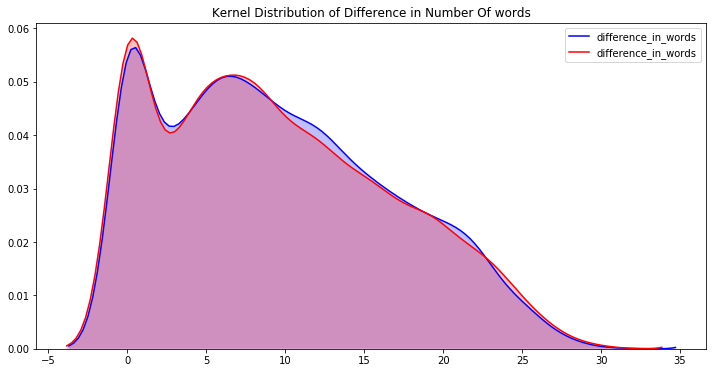

In [28]:
##############
##   PREP   ##
##############
plt.figure(figsize=(12,6))

mask_sentiment_pos = train['sentiment']=='positive'
difference_in_words_pos = train[mask_sentiment_pos]['difference_in_words']

mask_sentiment_neg = train['sentiment']=='negative'
difference_in_words_neg = train[mask_sentiment_neg]['difference_in_words']


################
##   ACTION   ##
################
p1=(sns
    .kdeplot(difference_in_words_pos, shade=True, color="b")
    .set_title('Kernel Distribution of Difference in Number Of words')
   )

p2=sns.kdeplot(difference_in_words_neg, shade=True, color="r")

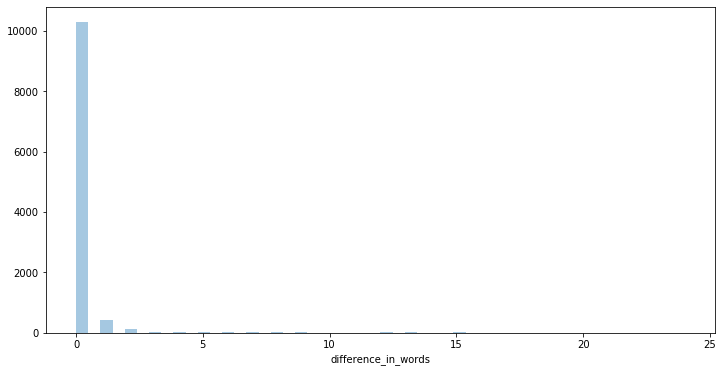

In [30]:
##############
##   PREP   ##
##############
plt.figure(figsize=(12,6))
mask_sentiment_neutral = train['sentiment']=='neutral'
difference_in_words_neutral = train[mask_sentiment_neutral]['difference_in_words']


################
##   ACTION   ##
################
sns.distplot(difference_in_words_neutral,kde=False)

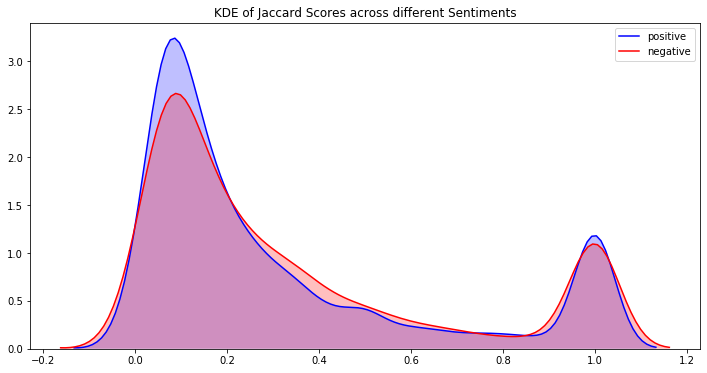

In [33]:
##############
##   PREP   ##
##############
plt.figure(figsize=(12,6))

mask_sentiment_pos = train['sentiment']=='positive'
jaccard_score_pos = train[mask_sentiment_pos]['jaccard_score']

mask_sentiment_neg = train['sentiment']=='negative'
jaccard_score_neg = train[mask_sentiment_neg]['jaccard_score']


################
##   ACTION   ##
################
p1=(sns
    .kdeplot(jaccard_score_pos, shade=True, color="b")
    .set_title('KDE of Jaccard Scores across different Sentiments')
   )

p2=sns.kdeplot(jaccard_score_neg, shade=True, color="r")

plt.legend(labels=['positive','negative'])

Text(0.5, 1.0, 'Histogram of Jaccard Scores for neutral Sentiments')

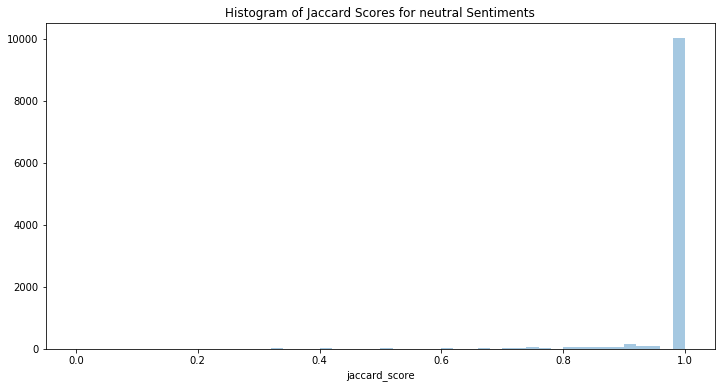

In [37]:
##############
##   PREP   ##
##############
plt.figure(figsize=(12,6))
mask_sentiment_neutral = train['sentiment']=='neutral'
jaccard_score_neutral = train[mask_sentiment_neutral]['jaccard_score']


################
##   ACTION   ##
################
(sns
 .distplot(jaccard_score_neutral,kde=False)
 .set_title('Histogram of Jaccard Scores for neutral Sentiments')
)

-----